In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

def count_images(directory):
    return {category: len(os.listdir(os.path.join(directory, category))) for category in ["NORMAL", "PNEUMONIA"]}

# Descargar y extraer el dataset (Ejecutar en local o en Colab con credenciales de Kaggle)
kaggle_dataset = "paultimothymooney/chest-xray-pneumonia"
!kaggle datasets download -d {kaggle_dataset} --unzip

dataset_path = "chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

print("Dataset inicial:")
print("Train:", count_images(train_dir))
print("Validation:", count_images(val_dir))
print("Test:", count_images(test_dir))

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:45<00:00, 23.3MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]
Dataset inicial:
Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 830ms/step - accuracy: 0.7809 - loss: 0.4811 - val_accuracy: 0.9183 - val_loss: 0.2702 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 825ms/step - accuracy: 0.9366 - loss: 0.2185 - val_accuracy: 0.8718 - val_loss: 0.3110 - learning_rate: 1.8000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - accuracy: 0.9483 - loss: 0.1807 - val_accuracy: 0.9183 - val_loss: 0.2595 - learning_rate: 2.6000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 801ms/step - accuracy: 0.9440 - loss: 0.1866 - val_accuracy: 0.9359 - val_loss: 0.2966 - learning_rate: 3.4000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 811ms/step - accuracy: 0.9418 - loss: 0.1978 - val_accuracy: 0.9119 - val_loss: 0.2259 - learning_rate: 4.2000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 812ms/step - accuracy: 0.9470 - loss: 0.1546 - val_accuracy: 0.8702 - val_loss: 0.3768 - learning_rate: 5.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 

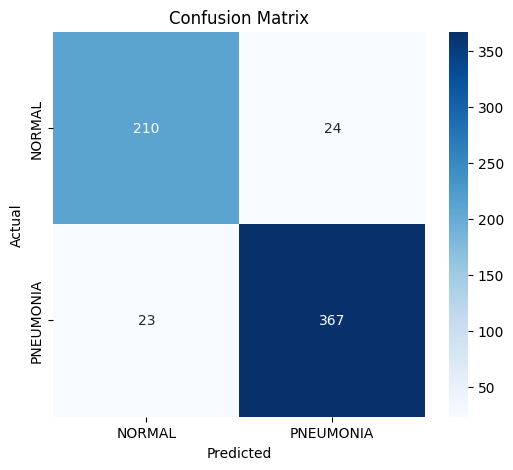

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios del dataset
dataset_path = "chest_xray"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# Parámetros
target_size = (256, 256)
batch_size = 32

# Generadores de datos con data augmentation más equilibrado
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Cálculo de class weights ajustado
classes = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Estrategia de ajuste del learning rate
def lr_schedule(epoch):
    if epoch < 5:
        return 1e-4 + (epoch * (5e-4 - 1e-4) / 5)  # Warm-up con límite en 0.0005
    return 5e-4 * np.exp(-0.1 * (epoch - 5))  # Decaimiento exponencial

# Modelo base VGG16
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_vgg.layers[:-6]:  # Descongelar solo las últimas 6 capas
    layer.trainable = False

# Capas superiores con regularización
x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model_vgg = Model(inputs=base_vgg.input, outputs=output)

# Compilación
optimizer = Adam(learning_rate=1e-4)
model_vgg.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    LearningRateScheduler(lr_schedule)
]

# Entrenamiento
history_vgg = model_vgg.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=callbacks, class_weight=class_weights)

# Evaluación
y_true = test_generator.classes
y_pred_probs = model_vgg.predict(test_generator)
y_pred = (y_pred_probs > 0.4).astype("int32")  # Umbral ajustado a 0.4

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()




20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step
              precision    recall  f1-score   support

      NORMAL       0.87      0.90      0.88       234
   PNEUMONIA       0.94      0.92      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



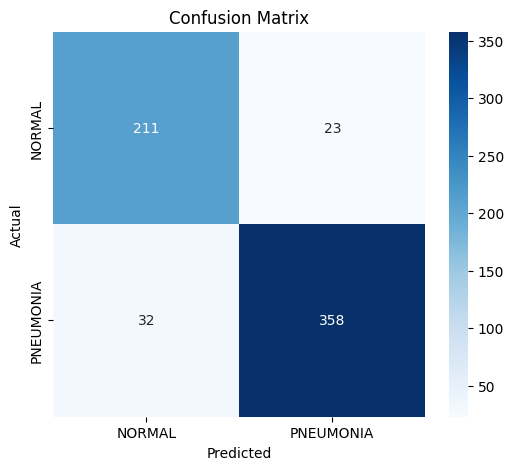

In [4]:
# Evaluación
y_true = test_generator.classes
y_pred_probs = model_vgg.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")  # Umbral ajustado a 0.5

print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [5]:
# Guardar el modelo CNN
model_vgg.save('model_vgg16.h5')

In [7]:
from google.colab import files

# Descargar el archivo guardado del modelo
files.download('model_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>